# Production System Simulation
## Modeling a Manufacturing Facility with Three Product Families

This notebook simulates a production system with:
- 6 working centers (each with capacity 1)
- 3 product families with different routing probabilities
- Gamma-distributed processing times
- Due dates uniformly distributed between 30-50 time units

Key performance indicators calculated:
- Work in Progress (WIP)
- Tardiness and Earliness (max and average)
- Throughput
- Working center utilization
- Job arrivals per family over time

In [232]:
# Install required packages
%pip install simpy numpy matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


In [233]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
plt.style.use('ggplot')

## Simulation Parameters

In [234]:
# Simulation configuration
SIM_TIME = 20_000  # Total simulation time
WARM_UP = 5_000    # Warm-up period to ignore in statistics (determined with Welch's method)

# Working center IDs
WC_IDS = [1, 2, 3, 4, 5, 6]

# Product family probabilities [F1, F2, F3]
FAMILY_PROBS = {1: 0.10, 2: 0.52, 3: 0.38}

# Gamma distribution parameters (alpha, beta) for each family
PROCESSING_PARAMS = {
    1: (2, 2),      # Family 1
    2: (4, 0.5),    # Family 2
    3: (6, 1/6)     # Family 3
}

# Routing logic: (WC, probability) for each family
ROUTING = {
    1: {1 : 1.0, 2 : 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
    2: {1: 0.8, 2: 0.8, 3: 1.0, 4: 0.8, 5: 0.8, 6: 0.75},
    3: {3: 1.0, 6: 0.75}
}

# Arrival rate (exponential distribution)
ARRIVAL_RATE = 0.65  # lambda

# Due times
DUE_TIME = (30, 50)

## System Visualization

Utility for visualizing service time distribution and routing probabilities for each product family.

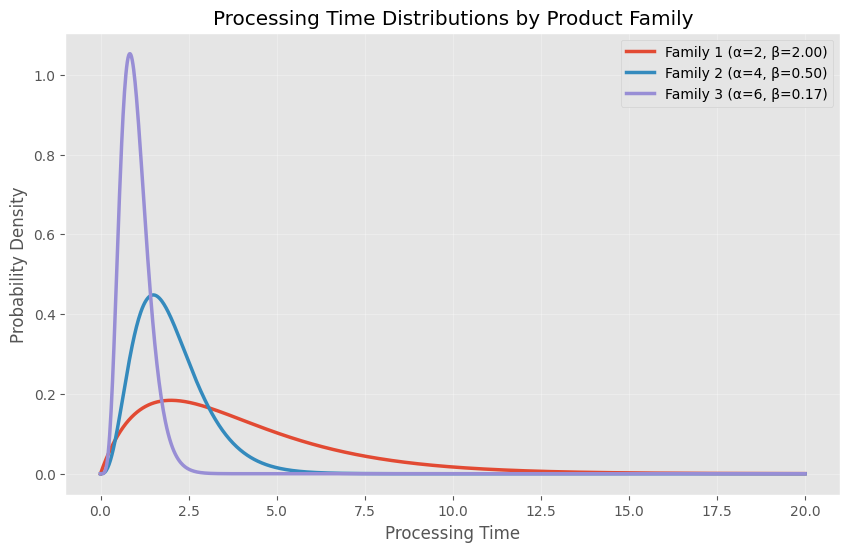

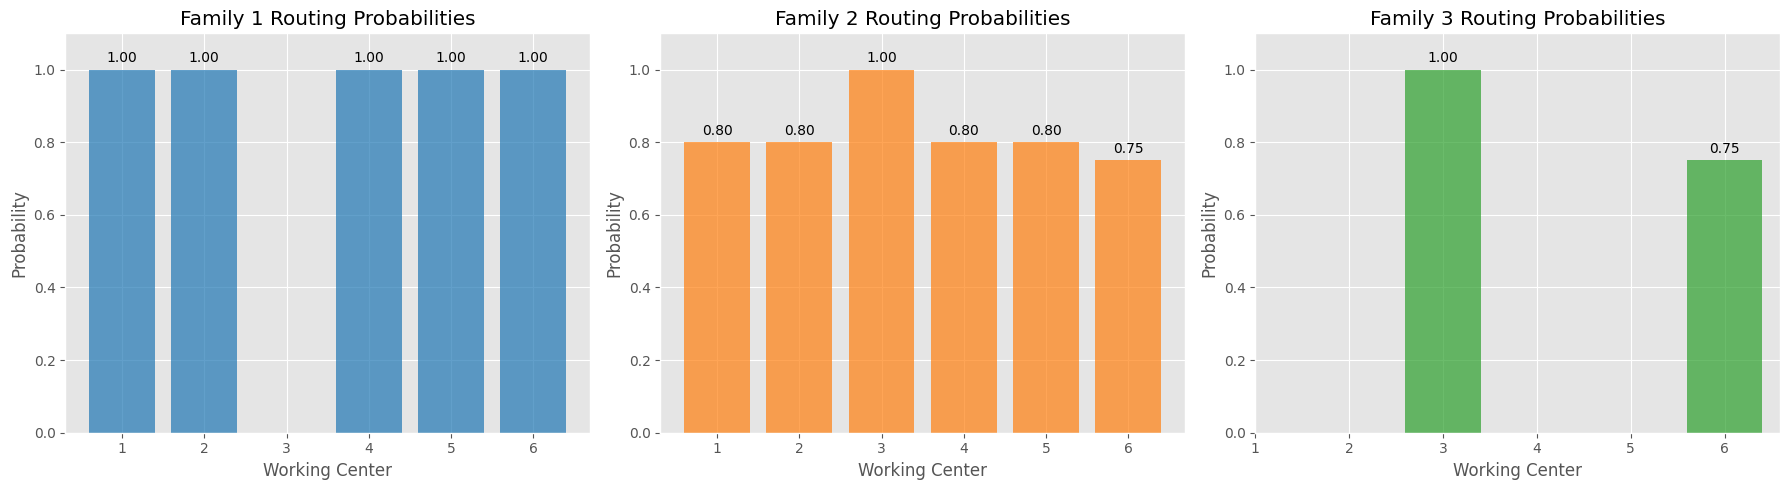

In [235]:
def visualize_processing_distributions():
    """Visualize gamma distributions for each product family"""
    plt.figure(figsize=(10, 6))
    
    # Generate x values
    x = np.linspace(0, 20, 1000)
    
    # Plot each family's distribution
    for family, (alpha, beta) in PROCESSING_PARAMS.items():
        y = gamma.pdf(x, alpha, scale=beta)
        plt.plot(x, y, label=f'Family {family} (α={alpha}, β={beta:.2f})', linewidth=2.5)
    
    plt.title('Processing Time Distributions by Product Family')
    plt.xlabel('Processing Time')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def visualize_routing_probabilities():
    """Visualize routing probabilities for each product family"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    wc_positions = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}
    
    for idx, (family, routing) in enumerate(ROUTING.items()):
        ax = axes[idx]
        wcs = [wc for wc, _ in routing.items()]
        probs = [prob for _, prob in routing.items()]
        
        # Create positions
        positions = [wc_positions[wc] for wc in wcs]
        
        ax.bar(positions, probs, color=plt.cm.tab10(family-1), alpha=0.7)
        ax.set_title(f'Family {family} Routing Probabilities')
        ax.set_xlabel('Working Center')
        ax.set_ylabel('Probability')
        ax.set_xticks(list(wc_positions.values()))
        ax.set_xticklabels(list(wc_positions.keys()))
        ax.set_ylim(0, 1.1)
        
        # Add value labels
        for i, p in enumerate(probs):
            ax.text(positions[i], p + 0.02, f'{p:.2f}', ha='center')
    
    plt.tight_layout()
    plt.show()

# Visualize system characteristics
visualize_processing_distributions()
visualize_routing_probabilities()

## Simulation Implementation

### Job class

Represents a production job with family, due date, and tracking times (arrival time, start time and finish time for each work center and completion time).

In [236]:
class Job:
    """Represents a production job with family, due date, and tracking times"""
    next_id = 1
    
    def __init__(self, env, family):
        self.jid = Job.next_id
        Job.next_id += 1
        self.family = family
        self.arrival_time = env.now
        self.due_date = self.arrival_time + random.uniform(DUE_TIME[0], DUE_TIME[1])
        self.start_times = {} # it stores the start times of processing for each machine which this job goes through
        self.finish_times = {} # it stores the finish times of processing for each machine which this job goes through
        self.completion_time: float | None = None
        
    def __repr__(self):
        return f"Job {self.jid} (F{self.family}) due @ {self.due_date:.2f}"
    
    def run(self, env : simpy.Environment, wcs : dict[int, simpy.Resource], stats, debug: bool = False):
        """Processes a job through its routing sequence"""
        # Record system statistics
        stats['generated'] += 1
        stats['wip_count'] += 1
        stats['wip_history'].append((env.now, stats['wip_count']))
        
        # Record family-specific statistics
        stats['family_counts'][self.family] += 1
        
        # Record arrival time for this family
        stats['arrival_times'][self.family].append(env.now)

        if debug:
            print(f"\n[🆕 ARRIVAL @ {env.now:.2f}] {self} ")

        for wc_id, prob in ROUTING[self.family].items():
            if random.random() < prob:  # Decide whether to visit this WC
                wc = wcs[wc_id]
                with wc.request() as req:
                    if debug:
                        print(f"[⏳ QUEUE @ {env.now:.2f}] {self} "
                            f"waiting for WC {wc_id}")
                    # Record queue start time
                    queue_start = env.now
                    
                    # Request the working center
                    yield req
                    
                    # Record queue time
                    queue_time = env.now - queue_start
                    stats['queue_times'][wc_id].append(queue_time)
                    
                    # Record processing start
                    self.start_times[wc_id] = env.now
                    
                    # Get processing time
                    alpha, beta = PROCESSING_PARAMS[self.family]
                    processing_time = random.gammavariate(alpha, beta)

                    if debug:
                        print(f"[⚙️ START @ {env.now:.2f}] {self} "
                            f"processing at WC {wc_id} for {processing_time:.2f} units")
                    
                    # Process the job
                    yield env.timeout(processing_time)
                    
                    # Record processing finish
                    self.finish_times[wc_id] = env.now
                    
                    # Update statistics
                    stats['wc_busy_time'][wc_id] += processing_time
                    stats['wc_utilization'][wc_id].append((env.now, stats['wc_busy_time'][wc_id] / env.now))

                    if debug:
                        print(f"[✅ FINISH @ {env.now:.2f}] {self} "
                            f"completed at WC {wc_id}")
        
        # Job completion
        self.completion_time = env.now
        stats['completed_jobs'].append(self)
        stats['wip_count'] -= 1
        stats['wip_history'].append((env.now, stats['wip_count']))

        # Calculate and record tardiness/earliness
        tardiness = max(0, self.completion_time - self.due_date)
        earliness = max(0, self.due_date - self.completion_time)

        if debug:
            print(f"\n[🏁 COMPLETE @ {env.now:.2f}] {self} "
                f"Tardiness: {tardiness:.2f} | Earliness: {earliness:.2f}")
        
        # Only record statistics after warm-up period
        if env.now > WARM_UP:
            stats['tardiness'].append(tardiness)
            stats['earliness'].append(earliness)
            stats['family_tardiness'][self.family].append(tardiness)
            stats['family_earliness'][self.family].append(earliness)
            
            # Update throughput counter
            stats['completed_after_warmup'] += 1
            
            # Update throughput immediately after completion
            elapsed_time = env.now - WARM_UP
            current_throughput = stats['completed_after_warmup'] / elapsed_time
            stats['throughput_over_time'].append((env.now, current_throughput))
            stats['last_throughput_sample_time'] = env.now

In [237]:
def job_generator(env, wcs, stats, debug: bool = False):
    """Generates jobs with exponential inter-arrival times"""
    while True:
        family = random.choices([1, 2, 3], weights=list(FAMILY_PROBS.values()))[0]
        job = Job(env, family)
        
        # Start processing this job
        env.process(job.run(env, wcs, stats, debug))
        
        # Wait for next arrival
        interarrival = random.expovariate(ARRIVAL_RATE)
        yield env.timeout(interarrival)

In [238]:
def run_simulation(simulation_time: float = SIM_TIME, debug: bool = False):
    """Run the simulation and return statistics"""
    if debug:
        print("="*80)
        print(f"DEBUG SIMULATION RUN ({simulation_time} TIME UNITS)")
        print("="*80)
    
    # Initialize environment
    env = simpy.Environment()
    
    # Initialize statistics collection
    stats = {
        'generated': 0,
        'completed_jobs': [],
        'completed_after_warmup': 0,
        'wip_count': 0,
        'wip_history': [],
        'wc_busy_time': {wc: 0 for wc in WC_IDS},
        'wc_utilization': {wc: [] for wc in WC_IDS},
        'queue_times': {wc: [] for wc in WC_IDS},
        'tardiness': [],
        'earliness': [],
        'family_counts': {1: 0, 2: 0, 3: 0},
        'family_tardiness': {1: [], 2: [], 3: []},
        'family_earliness': {1: [], 2: [], 3: []},
        'throughput_over_time': [],  # (time, current_throughput)
        'last_throughput_sample_time': WARM_UP,
        'arrival_times': {1: [], 2: [], 3: []}  # Track arrival times per family
    }
    
    # Create working centers (each as a Resource with capacity 1)
    wcs = {wc_id: simpy.Resource(env) for wc_id in WC_IDS}
    
    # Start processes
    env.process(job_generator(env, wcs, stats, debug))
    
    # Run simulation
    env.run(until=simulation_time)

    if debug:
        print("\n" + "="*80)
        print("DEBUG SIMULATION SUMMARY")
        print("="*80)
        print(f"Total jobs generated: {stats['generated']}")
        print(f"Jobs completed: {len(stats['completed_jobs'])}")
        print(f"Current WIP: {stats['wip_count']}")
        print(f"Family distribution: F1={stats['family_counts'][1]}, F2={stats['family_counts'][2]}, F3={stats['family_counts'][3]}")
        print("\nWorking Center Utilization:")
        for wc in WC_IDS:
            utilization = stats['wc_busy_time'][wc] / simulation_time
            print(f"  WC {wc}: {utilization:.2%}")
    
    return stats

In [239]:
def compute_kpis_from_stats(stats):
    """Compute KPIs from simulation statistics dictionary"""
    # Average wip
    wip_history = np.array(stats['wip_history'])
    wip_after_warmup = wip_history[wip_history[:,0] > WARM_UP]
    avg_wip = np.mean(wip_after_warmup[:,1]) if len(wip_after_warmup) > 0 else 0
    
    # Average tardiness
    avg_tardiness = np.mean(stats['tardiness']) if stats['tardiness'] else 0
    max_tardiness = np.max(stats['tardiness']) if stats['tardiness'] else 0

    # Average earliness
    avg_earliness = np.mean(stats['earliness']) if stats['earliness'] else 0
    max_earliness = np.max(stats['earliness']) if stats['earliness'] else 0

    # Throughput
    throughput = stats['completed_after_warmup'] / (SIM_TIME - WARM_UP)
    
    # Utilizations
    utilizations = {wc: stats['wc_busy_time'][wc] / SIM_TIME for wc in WC_IDS}
    
    # Queue times
    queue_times = {
                        wc: np.mean(stats['queue_times'][wc]) 
                        if stats['queue_times'][wc] else 0 
                        for wc in WC_IDS
                    }
    
    # Family-specific tardiness
    family_avg_tardiness = {
        fam: np.mean(tardiness) if tardiness else 0
        for fam, tardiness in stats['family_tardiness'].items()
    }
            
    return {
        'Average WIP': avg_wip,
        'Maximum Tardiness': max_tardiness,
        'Average Tardiness': avg_tardiness,
        'Maximum Earliness': max_earliness,
        'Average Earliness': avg_earliness,
        'Throughput (jobs/time unit)': throughput,
        'Working Center Utilization': utilizations,
        'Average Queue Times': queue_times,
        'Family Average Tardiness': family_avg_tardiness
    }

## Model verification

Run a small simulation with useful prints

In [240]:
DEBUG_SIMULATION_TIME = 20
random.seed(42)

_ = run_simulation(simulation_time=DEBUG_SIMULATION_TIME, debug=True)

DEBUG SIMULATION RUN (20 TIME UNITS)

[🆕 ARRIVAL @ 0.00] Job 1 (F3) due @ 30.50 
[⏳ QUEUE @ 0.00] Job 1 (F3) due @ 30.50 waiting for WC 3
[⚙️ START @ 0.00] Job 1 (F3) due @ 30.50 processing at WC 3 for 1.36 units

[🆕 ARRIVAL @ 0.49] Job 2 (F3) due @ 32.23 
[⏳ QUEUE @ 0.49] Job 2 (F3) due @ 32.23 waiting for WC 3

[🆕 ARRIVAL @ 1.34] Job 3 (F2) due @ 41.45 
[⏳ QUEUE @ 1.34] Job 3 (F2) due @ 41.45 waiting for WC 1
[⚙️ START @ 1.34] Job 3 (F2) due @ 41.45 processing at WC 1 for 2.53 units
[✅ FINISH @ 1.36] Job 1 (F3) due @ 30.50 completed at WC 3
[⏳ QUEUE @ 1.36] Job 1 (F3) due @ 30.50 waiting for WC 6
[⚙️ START @ 1.36] Job 1 (F3) due @ 30.50 processing at WC 6 for 1.11 units
[⚙️ START @ 1.36] Job 2 (F3) due @ 32.23 processing at WC 3 for 0.22 units

[🆕 ARRIVAL @ 1.38] Job 4 (F3) due @ 38.18 
[⏳ QUEUE @ 1.38] Job 4 (F3) due @ 38.18 waiting for WC 3
[✅ FINISH @ 1.58] Job 2 (F3) due @ 32.23 completed at WC 3
[⏳ QUEUE @ 1.58] Job 2 (F3) due @ 32.23 waiting for WC 6
[⚙️ START @ 1.58] Job 4 (F3

## Running the Simulation

In [241]:
random.seed(42)

# Run the simulation
print("Starting simulation...")
stats = run_simulation()
print("Simulation completed!")

# Filter out warm-up period jobs
completed_after_warmup = [job for job in stats['completed_jobs'] if job.arrival_time > WARM_UP]
num_completed = len(completed_after_warmup)

# Calculate KPIs
kpis = compute_kpis_from_stats(stats)

# Print summary statistics
print(f"\n{' Summary Statistics ':-^60}")
print(f"Total jobs generated: {stats['generated']}")
print(f"Jobs completed after warm-up: {num_completed}")
print(f"Family distribution: F1={stats['family_counts'][1]}, F2={stats['family_counts'][2]}, F3={stats['family_counts'][3]}")

print(f"\n{' Key Performance Indicators ':-^60}")
for k, v in kpis.items():
    if isinstance(v, dict):
        print(f"\n{k}:")
        for subk, subv in v.items():
            print(f"  {subk}: {subv:.4f}")
    else:
        print(f"{k}: {v:.4f}")

Starting simulation...
Simulation completed!

-------------------- Summary Statistics --------------------
Total jobs generated: 12940
Jobs completed after warm-up: 9579
Family distribution: F1=1304, F2=6692, F3=4944

---------------- Key Performance Indicators ----------------
Average WIP: 27.5485
Maximum Tardiness: 112.4613
Average Tardiness: 11.7967
Maximum Earliness: 48.5890
Average Earliness: 9.5614
Throughput (jobs/time unit): 0.6395

Working Center Utilization:
  1: 0.8030
  2: 0.7971
  3: 0.9120
  4: 0.8068
  5: 0.7918
  6: 0.9557

Average Queue Times:
  1: 7.5339
  2: 5.7007
  3: 10.6258
  4: 4.9136
  5: 5.0107
  6: 19.4693

Family Average Tardiness:
  1: 20.0342
  2: 16.5321
  3: 3.1645


# Model validation and results visualization

Verify run results against Little's law, expected utilization and expected throughput.

## Model validation

In [242]:
def verify_littles_law(stats, kpis):
    """Verify simulation results using Little's Law"""
    print("\n" + "="*80)
    print("ANALYTICAL VERIFICATION USING LITTLE'S LAW")
    print("="*80)
    
    # Get relevant statistics
    lambda_ = ARRIVAL_RATE  # Arrival rate (jobs/time unit)
    avg_wip = kpis['Average WIP']
    throughput = kpis['Throughput (jobs/time unit)']
    
    # Calculate average flow time from completed jobs
    flow_times = [
                    job.completion_time - job.arrival_time 
                    for job in stats['completed_jobs'] 
                    if job.arrival_time > WARM_UP
                ]
    avg_flow_time = np.mean(flow_times) if flow_times else 0
    
    # Little's Law: L = λ * W
    # Where:
    #   L = average number of items in the system (WIP)
    #   λ = long-term average arrival rate
    #   W = average time an item spends in the system (flow time)
    
    # Version 1: Using arrival rate
    calculated_wip = lambda_ * avg_flow_time
    
    # Version 2: Using throughput (more stable)
    calculated_wip_alt = throughput * avg_flow_time
    
    # Calculate flow time from WIP and throughput
    calculated_flow_time = avg_wip / throughput
    
    # Print results
    print(f"Input Arrival Rate (λ): {lambda_:.4f} jobs/time unit")
    print(f"Measured Throughput: {throughput:.4f} jobs/time unit")
    print(f"Average Flow Time (W): {avg_flow_time:.4f} time units")
    print(f"Average WIP (L) from simulation: {avg_wip:.4f}")
    print(f"Calculated WIP (λ * W): {calculated_wip:.4f}")
    print(f"Calculated WIP (Throughput * W): {calculated_wip_alt:.4f}")
    print(f"Calculated Flow Time (L / Throughput): {calculated_flow_time:.4f}")
    
    # Calculate differences
    diff_percent = abs(avg_wip - calculated_wip) / avg_wip * 100 if avg_wip > 0 else 0
    diff_percent_alt = abs(avg_wip - calculated_wip_alt) / avg_wip * 100 if avg_wip > 0 else 0
    flow_diff_percent = abs(avg_flow_time - calculated_flow_time) / avg_flow_time * 100 if avg_flow_time > 0 else 0
    
    print("\n" + "-"*80)
    print(f"Consistency Check Results:")
    print(f"  WIP Difference (λ*W vs simulation): {diff_percent:.2f}%")
    print(f"  WIP Difference (Throughput*W vs simulation): {diff_percent_alt:.2f}%")
    print(f"  Flow Time Difference: {flow_diff_percent:.2f}%")
    
    # Interpretation
    print("\n" + "-"*80)
    print("Interpretation:")
    if diff_percent < 5 and diff_percent_alt < 5 and flow_diff_percent < 5:
        print("✅ Excellent consistency with Little's law - Differences < 5%")
    elif diff_percent < 10 and diff_percent_alt < 10 and flow_diff_percent < 10:
        print("⚠️ Good consistency with Little's law - Differences < 10%")
    else:
        print("❌ Significant discrepancies with Little's law detected")

# Run verification if we have valid KPIs
if kpis and 'Average WIP' in kpis and 'Throughput (jobs/time unit)' in kpis:
    verify_littles_law(stats, kpis)
else:
    print("Skipping Little's Law verification - insufficient data")


ANALYTICAL VERIFICATION USING LITTLE'S LAW
Input Arrival Rate (λ): 0.6500 jobs/time unit
Measured Throughput: 0.6395 jobs/time unit
Average Flow Time (W): 42.2845 time units
Average WIP (L) from simulation: 27.5485
Calculated WIP (λ * W): 27.4849
Calculated WIP (Throughput * W): 27.0423
Calculated Flow Time (L / Throughput): 43.0759

--------------------------------------------------------------------------------
Consistency Check Results:
  WIP Difference (λ*W vs simulation): 0.23%
  WIP Difference (Throughput*W vs simulation): 1.84%
  Flow Time Difference: 1.87%

--------------------------------------------------------------------------------
Interpretation:
✅ Excellent consistency with Little's law - Differences < 5%


In [243]:
def wc_utilization_validation(stats, kpis):
    """Validate working center utilization analytically"""
    print("\n" + "="*80)
    print("WORKING CENTER UTILIZATION VALIDATION")
    print("="*80)
    print("This validation compares simulated utilization with theoretical expectations\n")
    
    # Configuration parameters
    gamma_means = {fam: alpha*beta for fam, (alpha, beta) in PROCESSING_PARAMS.items()}
    
    # Calculate arrival rate to each WC
    wc_arrival_rates = {wc: 0.0 for wc in WC_IDS}
    for family in [1, 2, 3]:
        for wc, prob in ROUTING[family].items():
            wc_arrival_rates[wc] += ARRIVAL_RATE * FAMILY_PROBS[family] * prob
    
    # Calculate expected utilization for each WC
    util_results = []
    for wc in WC_IDS:
        arrival_rate = wc_arrival_rates[wc]
        
        # Calculate weighted average processing time for this WC
        processing_times = []
        weights = []
        for family in [1, 2, 3]:
            if wc in ROUTING[family]:
                weight = ARRIVAL_RATE * FAMILY_PROBS[family] * ROUTING[family][wc]
                weights.append(weight)
                processing_times.append(gamma_means[family])
        
        if weights:
            # Calculate weighted average processing time
            total_weight = sum(weights)
            weights = [w/total_weight for w in weights]  # Normalize weights
            avg_processing_time = sum(p * w for p, w in zip(processing_times, weights))
            
            # Utilization = Arrival Rate × Average Processing Time
            expected_util = arrival_rate * avg_processing_time
            simulated_util = kpis['Working Center Utilization'][wc]
            diff = abs(expected_util - simulated_util)
            diff_percent = diff / simulated_util * 100 if simulated_util > 0 else 0
            
            util_results.append({
                'WC': wc,
                'Expected': expected_util,
                'Simulated': simulated_util,
                'Difference (%)': diff_percent
            })
    
    # Print results
    print("{:<5} {:<12} {:<12} {:<12}".format('WC', 'Expected', 'Simulated', 'Difference (%)'))
    print("-" * 45)
    for res in util_results:
        print("{:<5} {:<12.4f} {:<12.4f} {:<12.2f}%".format(
            f"WC {res['WC']}", 
            res['Expected'], 
            res['Simulated'], 
            res['Difference (%)']
        ))
    
    # Interpretation
    print("\nValidation Summary:")
    print(f"- Average difference: {np.mean([res['Difference (%)'] for res in util_results]):.2f}%")
    print(f"- Maximum difference: {np.max([res['Difference (%)'] for res in util_results]):.2f}%")
    
    if all(res['Difference (%)'] < 10 for res in util_results):
        print("✅ Validation PASSED - All utilizations within 10% of theoretical values")
    elif all(res['Difference (%)'] < 15 for res in util_results):
        print("⚠️ Validation ACCEPTABLE - All utilizations within 15% of theoretical values")
    else:
        print("❌ Validation FAILED - Some utilizations differ significantly from theoretical values")

# Run WC utilization validation
if kpis and 'Working Center Utilization' in kpis:
    wc_utilization_validation(stats, kpis)
else:
    print("Skipping WC utilization validation - insufficient data")


WORKING CENTER UTILIZATION VALIDATION
This validation compares simulated utilization with theoretical expectations

WC    Expected     Simulated    Difference (%)
---------------------------------------------
WC 1  0.8008       0.8030       0.27        %
WC 2  0.8008       0.7971       0.46        %
WC 3  0.9230       0.9120       1.20        %
WC 4  0.8008       0.8068       0.74        %
WC 5  0.8008       0.7918       1.13        %
WC 6  0.9522       0.9557       0.36        %

Validation Summary:
- Average difference: 0.70%
- Maximum difference: 1.20%
✅ Validation PASSED - All utilizations within 10% of theoretical values


In [244]:
def throughput_validation(stats, kpis):
    """Validate throughput analytically"""
    print("\n" + "="*80)
    print("THROUGHPUT VALIDATION")
    print("="*80)
    print("This validation compares simulated throughput with theoretical expectations\n")
    
    # Theoretical throughput should equal arrival rate in stable systems
    expected_throughput = ARRIVAL_RATE
    simulated_throughput = kpis['Throughput (jobs/time unit)']
    
    # Calculate difference
    diff = abs(expected_throughput - simulated_throughput)
    diff_percent = diff / expected_throughput * 100
    
    # Print results
    print("{:<12} {:<12} {:<12}".format('Metric', 'Expected', 'Simulated'))
    print("-" * 35)
    print("{:<12} {:<12.4f} {:<12.4f}".format(
        'Throughput', 
        expected_throughput, 
        simulated_throughput
    ))
    print("\n{:<12} {:<12.2f}%".format('Difference', diff_percent))
    
    # Interpretation
    print("\nValidation Summary:")
    if diff_percent < 2:
        print("✅ Excellent match between thoretical and expected throughput - Difference < 2%")
    elif diff_percent < 5:
        print("⚠️ Good match between thoretical and expected throughput - Difference < 5%")
    elif diff_percent < 10:
        print("⚠️ Acceptable match between thoretical and expected throughput - Difference < 10%")
    else:
        print("❌ Significant discrepancy between thoretical and expected throughput - Difference ≥ 10%")

# Run throughput validation
if kpis and 'Throughput (jobs/time unit)' in kpis:
    throughput_validation(stats, kpis)
else:
    print("Skipping throughput validation - insufficient data")


THROUGHPUT VALIDATION
This validation compares simulated throughput with theoretical expectations

Metric       Expected     Simulated   
-----------------------------------
Throughput   0.6500       0.6395      

Difference   1.61        %

Validation Summary:
✅ Excellent match between thoretical and expected throughput - Difference < 2%


## Results Visualization

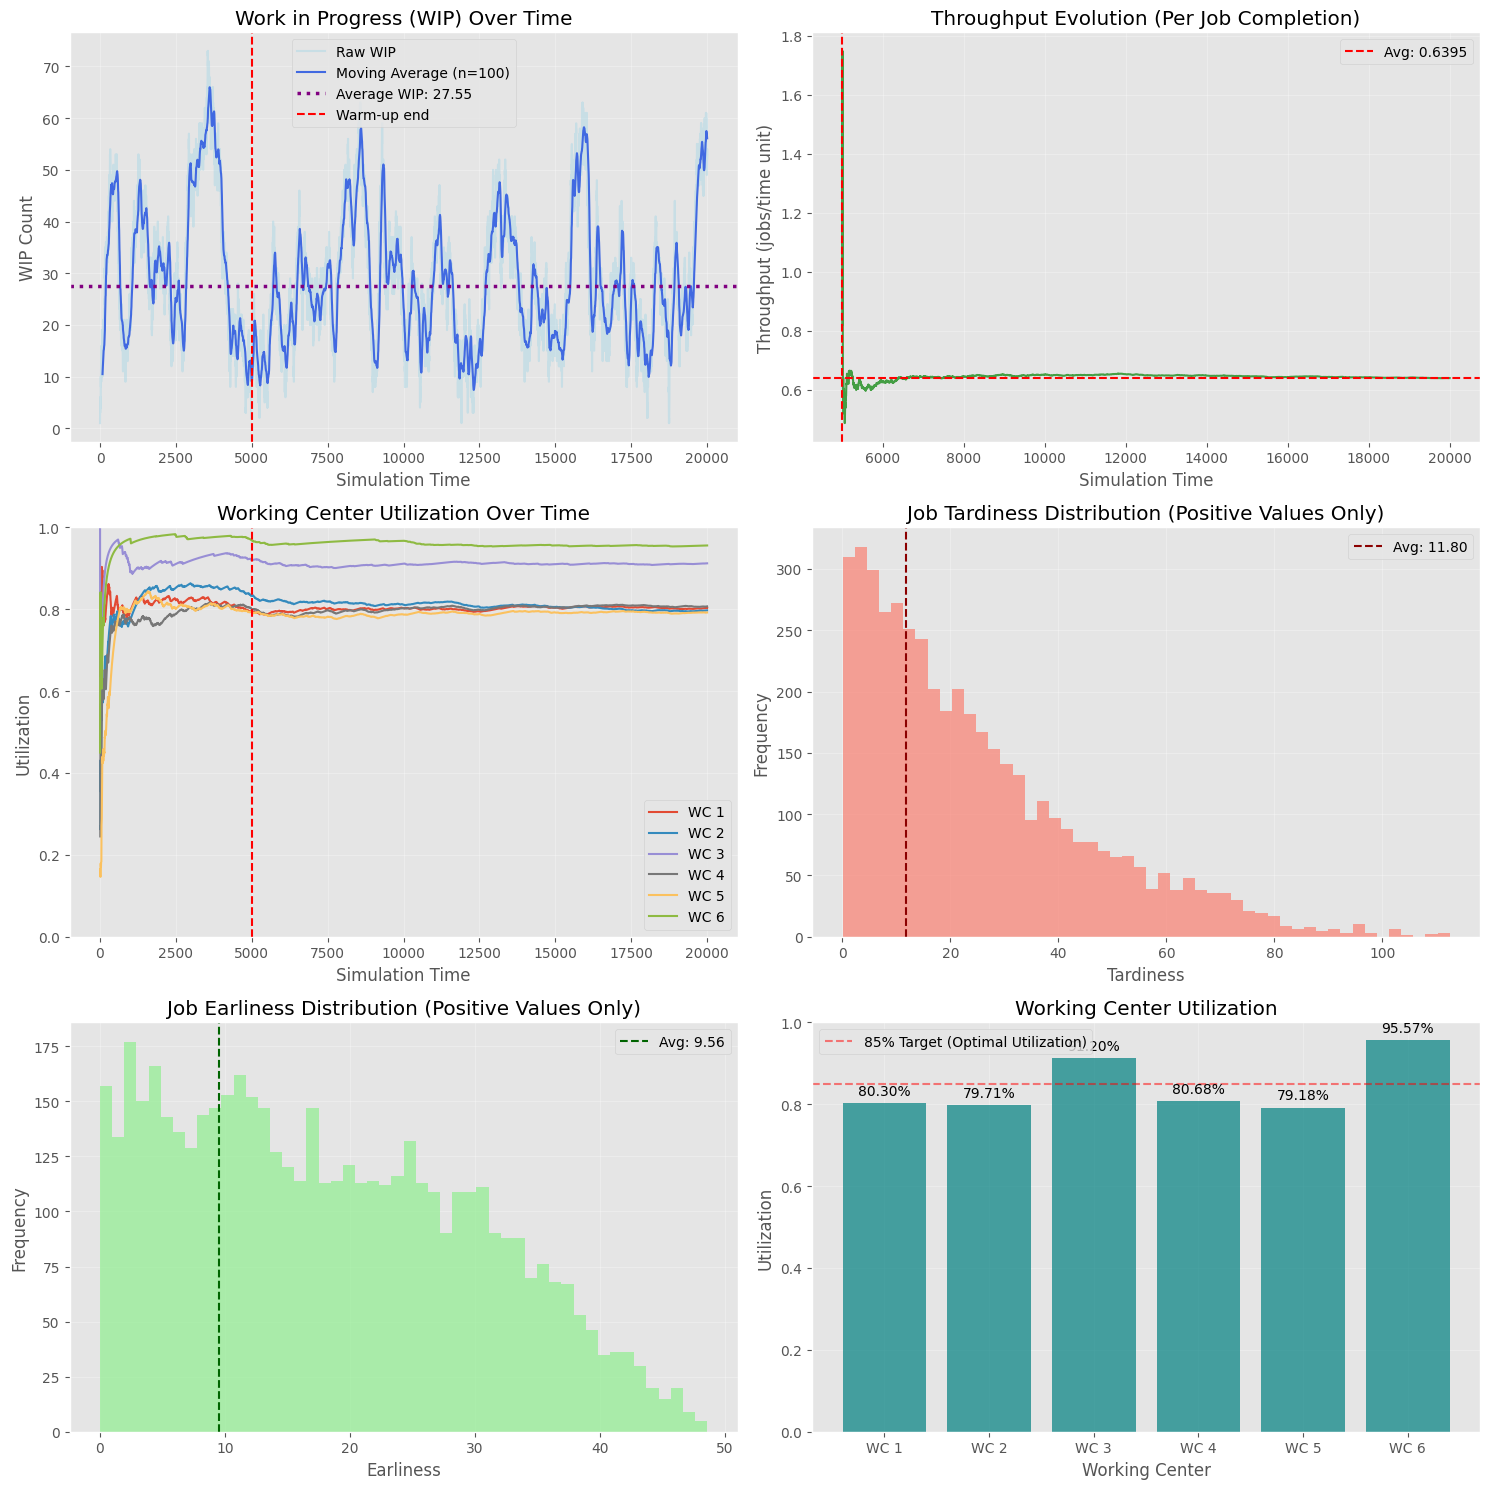

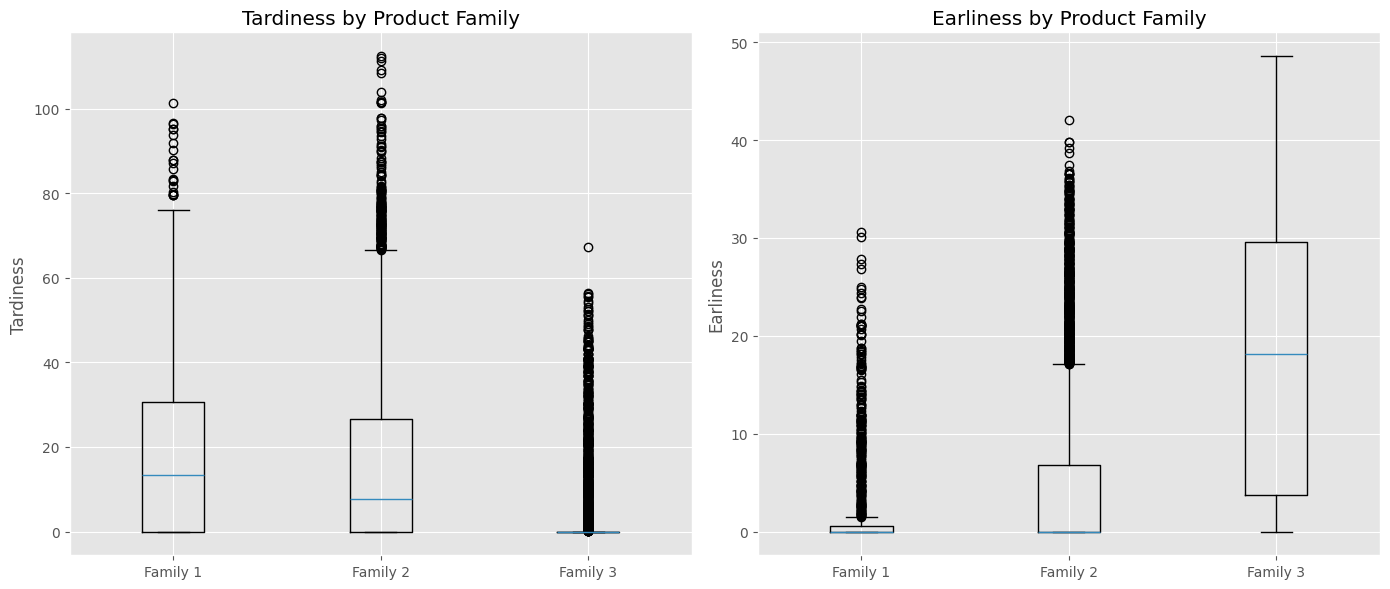

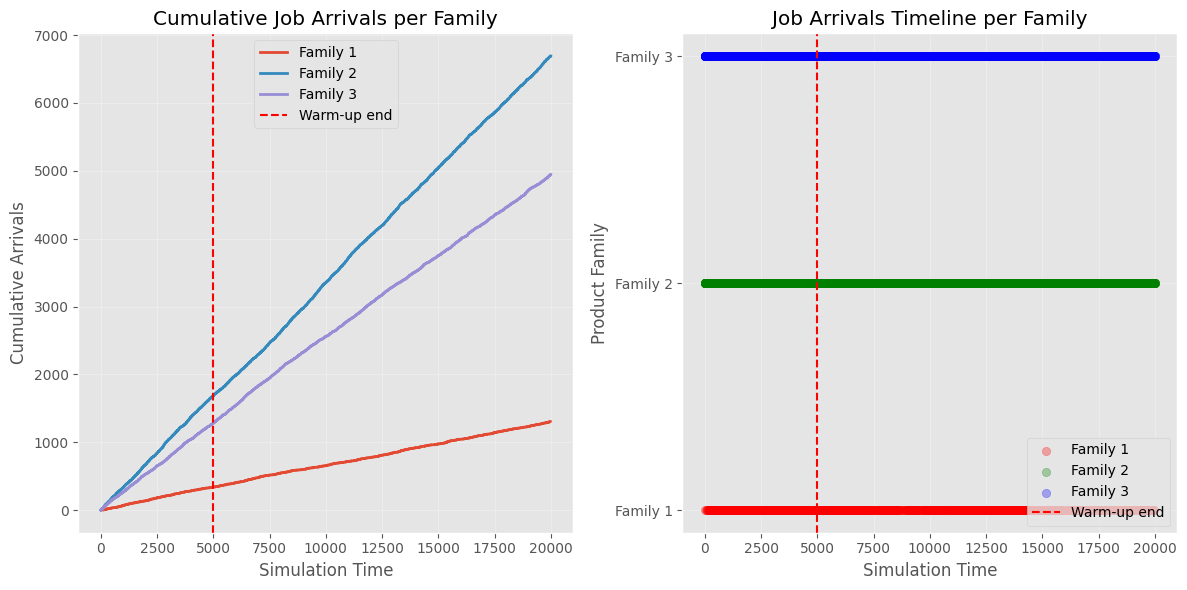

In [245]:
def visualize_results(stats, kpis):
    """Create visualizations of simulation results"""
    # Create figure layout
    plt.figure(figsize=(15, 15))
    
    # WIP over time with moving average and average WIP line
    plt.subplot(3, 2, 1)
    wip_time, wip_count = zip(*stats['wip_history'])
    
    # Calculate moving average (window size = 100 points)
    window_size = 100
    moving_avg = np.convolve(wip_count, np.ones(window_size)/window_size, mode='valid')
    
    # Get average WIP from KPIs
    avg_wip = kpis['Average WIP']
    
    # Plot both raw and smoothed data
    plt.plot(wip_time, wip_count, color='lightblue', alpha=0.5, label='Raw WIP')
    plt.plot(wip_time[window_size-1:], moving_avg, color='royalblue', label=f'Moving Average (n={window_size})')
    
    # Add dotted line for average WIP
    plt.axhline(avg_wip, color='purple', linestyle=':', linewidth=2.5, 
                label=f'Average WIP: {avg_wip:.2f}')
    
    plt.axvline(WARM_UP, color='r', linestyle='--', label='Warm-up end')
    plt.title('Work in Progress (WIP) Over Time')
    plt.xlabel('Simulation Time')
    plt.ylabel('WIP Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Throughput over time (updated per completion)
    plt.subplot(3, 2, 2)
    if stats['throughput_over_time']:
        t_time, throughput = zip(*stats['throughput_over_time'])
        plt.plot(t_time, throughput, 'g-', alpha=0.7)
        plt.axhline(kpis['Throughput (jobs/time unit)'], color='r', linestyle='--', 
                   label=f'Avg: {kpis["Throughput (jobs/time unit)"]:.4f}')
        plt.axvline(WARM_UP, color='r', linestyle='--')
        plt.title('Throughput Evolution (Per Job Completion)')
        plt.xlabel('Simulation Time')
        plt.ylabel('Throughput (jobs/time unit)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Utilization over time
    plt.subplot(3, 2, 3)
    for wc in WC_IDS:
        if stats['wc_utilization'][wc]:
            util_time, util = zip(*stats['wc_utilization'][wc])
            plt.plot(util_time, util, label=f'WC {wc}')
    plt.axvline(WARM_UP, color='r', linestyle='--')
    plt.title('Working Center Utilization Over Time')
    plt.xlabel('Simulation Time')
    plt.ylabel('Utilization')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Tardiness distribution (only positive values)
    plt.subplot(3, 2, 4)
    if stats['tardiness']:
        # Filter out zero tardiness values
        positive_tardiness = [t for t in stats['tardiness'] if t > 0]
        
        if positive_tardiness:
            plt.hist(positive_tardiness, bins=50, color='salmon', alpha=0.7)
            plt.axvline(kpis['Average Tardiness'], color='darkred', 
                       linestyle='--', label=f'Avg: {kpis["Average Tardiness"]:.2f}')
            plt.title('Job Tardiness Distribution (Positive Values Only)')
            plt.xlabel('Tardiness')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    # Earliness distribution (only positive values)
    plt.subplot(3, 2, 5)
    if stats['earliness']:
        # Filter out zero earliness values
        positive_earliness = [e for e in stats['earliness'] if e > 0]
        
        if positive_earliness:
            plt.hist(positive_earliness, bins=50, color='lightgreen', alpha=0.7)
            plt.axvline(kpis['Average Earliness'], color='darkgreen', 
                       linestyle='--', label=f'Avg: {kpis["Average Earliness"]:.2f}')
            plt.title('Job Earliness Distribution (Positive Values Only)')
            plt.xlabel('Earliness')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    # Utilization bar chart with 85% target
    plt.subplot(3, 2, 6)
    wcs = list(kpis['Working Center Utilization'].keys())
    utils = [kpis['Working Center Utilization'][wc] for wc in wcs]
    plt.bar([f'WC {wc}' for wc in wcs], utils, color='teal', alpha=0.7)
    
    # 85% target line explanation
    plt.axhline(0.85, color='r', linestyle='--', alpha=0.5, 
               label='85% Target (Optimal Utilization)')
    plt.title('Working Center Utilization')
    plt.xlabel('Working Center')
    plt.ylabel('Utilization')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(utils):
        plt.text(i, v + 0.02, f"{v:.2%}", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Family-specific performance
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Family tardiness
    family_tardiness = [
        stats['family_tardiness'][1],
        stats['family_tardiness'][2],
        stats['family_tardiness'][3]
    ]
    axes[0].boxplot(family_tardiness, 
                   tick_labels=['Family 1', 'Family 2', 'Family 3'])
    axes[0].set_title('Tardiness by Product Family')
    axes[0].set_ylabel('Tardiness')
    
    # Family earliness
    family_earliness = [
        stats['family_earliness'][1],
        stats['family_earliness'][2],
        stats['family_earliness'][3]
    ]
    axes[1].boxplot(family_earliness, 
                   tick_labels=['Family 1', 'Family 2', 'Family 3'])
    axes[1].set_title('Earliness by Product Family')
    axes[1].set_ylabel('Earliness')
    
    plt.tight_layout()
    plt.show()
    
    # Job arrivals per family over time
    plt.figure(figsize=(12, 6))
    
    # Cumulative arrivals
    plt.subplot(1, 2, 1)
    for family in [1, 2, 3]:
        arrival_times = sorted(stats['arrival_times'][family])
        cumulative_counts = np.arange(1, len(arrival_times) + 1)
        plt.step(arrival_times, cumulative_counts, where='post', 
                label=f'Family {family}', linewidth=2)
    
    plt.axvline(WARM_UP, color='r', linestyle='--', label='Warm-up end')
    plt.title('Cumulative Job Arrivals per Family')
    plt.xlabel('Simulation Time')
    plt.ylabel('Cumulative Arrivals')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Arrival events timeline
    plt.subplot(1, 2, 2)
    colors = {1: 'red', 2: 'green', 3: 'blue'}
    for family in [1, 2, 3]:
        arrival_times = stats['arrival_times'][family]
        plt.scatter(arrival_times, [family]*len(arrival_times), 
                   color=colors[family], alpha=0.3, label=f'Family {family}')
    
    plt.axvline(WARM_UP, color='r', linestyle='--', label='Warm-up end')
    plt.title('Job Arrivals Timeline per Family')
    plt.xlabel('Simulation Time')
    plt.ylabel('Product Family')
    plt.yticks([1, 2, 3], ['Family 1', 'Family 2', 'Family 3'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize results
if kpis:
    visualize_results(stats, kpis)

# Compute confidence intervals

In [246]:
# Confidence Interval Calculation
import scipy.stats

def sequential_confidence_interval(primary_metric: str = 'Average Tardiness', alpha=0.05, gamma=0.05):
    """Compute confidence intervals using sequential procedure"""
    n0 = 10
    n = n0
    replications = []
    primary_metric_values = []
    
    print(f"Running sequential confidence interval procedure (α={alpha}, γ={gamma})")
    print(f'Primary metric: {primary_metric}')
    print(f"Initial replications: {n0}")
    
    # Run initial replications
    for i in range(n0):
        print(f"  Running replication {i+1}/{n0}")
        stats = run_simulation()
        kpis = compute_kpis_from_stats(stats)
        replications.append(kpis)
        primary_metric_values.append(kpis[primary_metric])
    
    # Sequential procedure
    converged = False
    
    while not converged:
        # Calculate statistics for primary metric (average tardiness)
        X = np.array(primary_metric_values)
        X_bar = np.mean(X)
        S2 = np.var(X, ddof=1)  # Sample variance
        
        # Skip if no variance
        if S2 == 0 or len(X) == 1:
            half_width = 0
            rel_error = 0
        else:
            t_value = scipy.stats.t.ppf(1 - alpha/2, n-1)
            half_width = t_value * np.sqrt(S2 / n)
            rel_error = half_width / abs(X_bar) if X_bar != 0 else float('inf')
        
        print(f"Replications: {n}, Mean tardiness: {X_bar:.4f}, "
              f"Half-width: {half_width:.4f}, Rel error: {rel_error:.4f}")
        
        # Check convergence
        if rel_error <= gamma:
            converged = True
            print(f"\nConverged after {n} replications with relative error {rel_error:.4f} <= {gamma}")
        else:
            n += 1
            print(f"  Running additional replication {n}")
            stats = run_simulation()
            kpis = compute_kpis_from_stats(stats)
            replications.append(kpis)
            primary_metric_values.append(kpis[primary_metric])
    
    # Compute final confidence intervals for all KPIs
    confidence_intervals = {}
    
    # Scalar KPIs
    for k in ['Average WIP', 'Average Tardiness', 'Average Earliness', 'Throughput (jobs/time unit)']:
        values = [rep[k] for rep in replications]
        X = np.array(values)
        X_bar = np.mean(X)
        S2 = np.var(X, ddof=1)
        
        if n > 1:
            t_value = scipy.stats.t.ppf(1 - alpha/2, n-1)
            half_width = t_value * np.sqrt(S2 / n)
        else:
            half_width = 0
            
        confidence_intervals[k] = {
            'mean': X_bar,
            'ci_lower': X_bar - half_width,
            'ci_upper': X_bar + half_width,
            'half_width': half_width
        }
    
    # WC utilization
    wc_util_ci = {}
    for wc in WC_IDS:
        values = [rep['Working Center Utilization'][wc] for rep in replications]
        X = np.array(values)
        X_bar = np.mean(X)
        S2 = np.var(X, ddof=1)
        
        if n > 1:
            t_value = scipy.stats.t.ppf(1 - alpha/2, n-1)
            half_width = t_value * np.sqrt(S2 / n)
        else:
            half_width = 0
            
        wc_util_ci[wc] = {
            'mean': X_bar,
            'ci_lower': X_bar - half_width,
            'ci_upper': X_bar + half_width,
            'half_width': half_width
        }
    confidence_intervals['Working Center Utilization'] = wc_util_ci
    
    # WC queue times
    wc_queue_ci = {}
    for wc in WC_IDS:
        values = [rep['Average Queue Times'][wc] for rep in replications]
        X = np.array(values)
        X_bar = np.mean(X)
        S2 = np.var(X, ddof=1)
        
        if n > 1:
            t_value = scipy.stats.t.ppf(1 - alpha/2, n-1)
            half_width = t_value * np.sqrt(S2 / n)
        else:
            half_width = 0
            
        wc_queue_ci[wc] = {
            'mean': X_bar,
            'ci_lower': X_bar - half_width,
            'ci_upper': X_bar + half_width,
            'half_width': half_width
        }
    confidence_intervals['Average Queue Times'] = wc_queue_ci
    
    return confidence_intervals, n

# Run the confidence interval calculation
ALPHA = 0.05  # 95% confidence level
GAMMA = 0.05  # 5% relative error

print("\n" + "="*80)
print(" Calculating Confidence Intervals ".center(80, '='))
print("="*80)

random.seed(42)  # For reproducibility
confidence_intervals, n_reps = sequential_confidence_interval(
    primary_metric='Average Tardiness',alpha=ALPHA, gamma=GAMMA
)


======================= Calculating Confidence Intervals =======================
Running sequential confidence interval procedure (α=0.05, γ=0.05)
Primary metric: Average Tardiness
Initial replications: 10
  Running replication 1/10
  Running replication 2/10
  Running replication 3/10
  Running replication 4/10
  Running replication 5/10
  Running replication 6/10
  Running replication 7/10
  Running replication 8/10
  Running replication 9/10
  Running replication 10/10
Replications: 10, Mean tardiness: 21.9222, Half-width: 6.5499, Rel error: 0.2988
  Running additional replication 11
Replications: 11, Mean tardiness: 23.5508, Half-width: 6.8718, Rel error: 0.2918
  Running additional replication 12
Replications: 12, Mean tardiness: 24.0908, Half-width: 6.3096, Rel error: 0.2619
  Running additional replication 13
Replications: 13, Mean tardiness: 23.9399, Half-width: 5.7549, Rel error: 0.2404
  Running additional replication 14
Replications: 14, Mean tardiness: 23.5820, Half-width:

In [247]:
# Print confidence interval results
def print_confidence_intervals(ci_dict):
    print("\n" + " Confidence Intervals ".center(80, '-'))
    for metric, data in ci_dict.items():
        if isinstance(data, dict) and 'mean' in data:
            # Scalar metric
            print(f"{metric.replace('_', ' ').title()}:")
            print(f"  Mean: {data['mean']:.4f}")
            print(f"  95% CI: ({data['ci_lower']:.4f}, {data['ci_upper']:.4f})")
            print(f"  Half-width: {data['half_width']:.4f}")
            print(f"  Relative Precision: {data['half_width']/abs(data['mean']):.4f}" 
                  if data['mean'] != 0 else "  Relative Precision: undefined (mean=0)")
        elif isinstance(data, dict):
            # Nested dictionary (WC metrics)
            print(f"\n{metric.replace('_', ' ').title()}:")
            for wc, wc_data in data.items():
                print(f"  WC {wc}:")
                print(f"    Mean: {wc_data['mean']:.4f}")
                print(f"    95% CI: ({wc_data['ci_lower']:.4f}, {wc_data['ci_upper']:.4f})")
                print(f"    Half-width: {wc_data['half_width']:.4f}")
                print(f"    Relative Precision: {wc_data['half_width']/abs(wc_data['mean']):.4f}" 
                      if wc_data['mean'] != 0 else "    Relative Precision: undefined (mean=0)")

print_confidence_intervals(confidence_intervals)


----------------------------- Confidence Intervals -----------------------------
Average Wip:
  Mean: 34.7972
  95% CI: (33.9993, 35.5952)
  Half-width: 0.7979
  Relative Precision: 0.0229
Average Tardiness:
  Mean: 21.1315
  95% CI: (20.0778, 22.1852)
  Half-width: 1.0537
  Relative Precision: 0.0499
Average Earliness:
  Mean: 8.3428
  95% CI: (8.1853, 8.5003)
  Half-width: 0.1575
  Relative Precision: 0.0189
Throughput (Jobs/Time Unit):
  Mean: 0.6498
  95% CI: (0.6492, 0.6505)
  Half-width: 0.0007
  Relative Precision: 0.0011

Working Center Utilization:
  WC 1:
    Mean: 0.8006
    95% CI: (0.7994, 0.8019)
    Half-width: 0.0013
    Relative Precision: 0.0016
  WC 2:
    Mean: 0.8000
    95% CI: (0.7988, 0.8013)
    Half-width: 0.0013
    Relative Precision: 0.0016
  WC 3:
    Mean: 0.9214
    95% CI: (0.9204, 0.9225)
    Half-width: 0.0011
    Relative Precision: 0.0011
  WC 4:
    Mean: 0.7995
    95% CI: (0.7983, 0.8007)
    Half-width: 0.0012
    Relative Precision: 0.0016
  W